# PyTorch workflow fundamentals

## Import libraries

Let us first import the awsome stuff from PyTorch API that makes things work

In [55]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(torch.__version__)

2.2.0


## Create custom data with known parameters

### Let us assume w as 0.9 and b as 0.2. We shall create features and labels based on these parameters and check if the Linear Regression models can estimate them accurately

In [56]:
w = 0.9
b = 0.2

X = torch.arange(-2,2,0.02)
y = (w*X) + b

print(X.shape, y.shape)

torch.Size([200]) torch.Size([200])


We're hoping that the model we build would derive the parameter values close to 0.9 and 0.2

## Split the data into train set and test set

In [57]:
split_percent = int(len(X)*0.8)

X_train = X[:split_percent]
y_train = y[:split_percent]

X_test = X[split_percent:]
y_test = y[split_percent:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([160]) torch.Size([160]) torch.Size([40]) torch.Size([40])


## Plot predictions

In [58]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

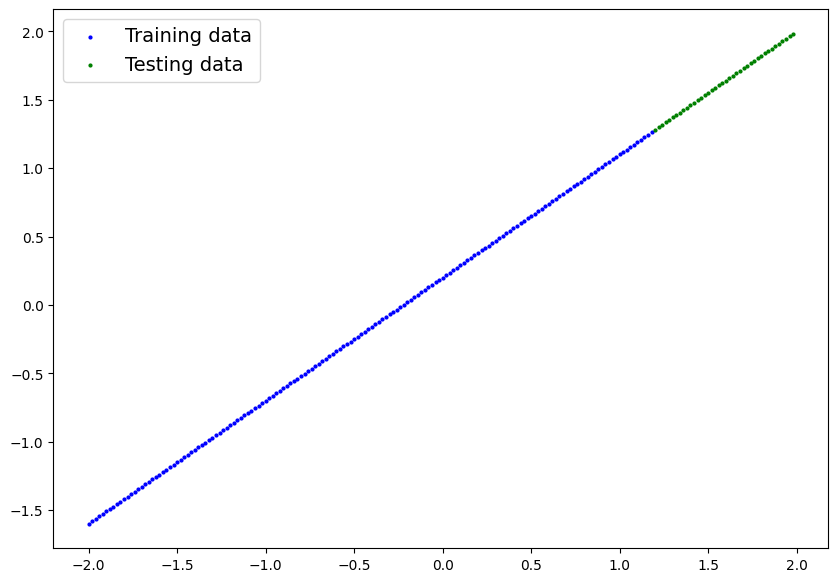

In [59]:
plot_predictions()

# Build model

In [60]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

`nn.Module` contains all the building blocks for neural networks

Initiate random parameters using `nn.Parameter` which will be optimized to produce desired outputs

Setting `requires_grad` to `True` makes sure that the model tracks the gradients and updates the values based on the loss

`def forward()` method defines the computation that will take place on the data passed to the particular nn.Module

In [61]:
torch.manual_seed(42)

model = LinearRegressionModel()

# list(model.parameters())

model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

`model.state_dict()` shows the values of the parameters of the model, in its current state

The values are random right now as we initiated them to be random float tensors using `torch.randn()`

The model in its current state will have poor predictive power

In [62]:
#Create loss function and optimizer

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = 0.01)

We pick a loss function for the model to optimize. Minimizing the loss function is how the model learns to predict the parameters. The type of loss function we choose depends on the kind of problem we're tackling.

## Creating an optimizing loop

In [63]:
# set the number of epochs
epochs = 100

# track the loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

## training
for epoch in range(epochs):

    # put the model in training mode
    model.train()

    # make a forward pass on the training data
    y_pred = model(X_train)

    # calculate the loss
    loss = loss_fn(y_pred,y_train)

    # set the gradient values to zero
    optimizer.zero_grad()

    # calculate the gradients with backward pass
    loss.backward()

    # update the parameters with the optimizer
    optimizer.step()

    # set the model in evaluation mode
    model.eval()

    # forward pass on the test data
    with torch.inference_mode():
        test_pred = model(X_test)

    # calculate the test loss
    test_loss = loss_fn(test_pred,y_test.type(torch.float))

    # track the results
    if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss} ")

Epoch: 0 | MSE Train Loss: 0.2962924838066101 | MSE Test Loss: 0.9397484660148621 
Epoch: 10 | MSE Train Loss: 0.18463216722011566 | MSE Test Loss: 0.8132736086845398 
Epoch: 20 | MSE Train Loss: 0.12083949893712997 | MSE Test Loss: 0.6221445798873901 
Epoch: 30 | MSE Train Loss: 0.0742688775062561 | MSE Test Loss: 0.3827635645866394 
Epoch: 40 | MSE Train Loss: 0.04069836437702179 | MSE Test Loss: 0.19676688313484192 
Epoch: 50 | MSE Train Loss: 0.02053447626531124 | MSE Test Loss: 0.09139491617679596 
Epoch: 60 | MSE Train Loss: 0.009218157269060612 | MSE Test Loss: 0.040969368070364 
Epoch: 70 | MSE Train Loss: 0.003605420934036374 | MSE Test Loss: 0.016948359087109566 
Epoch: 80 | MSE Train Loss: 0.0011984150623902678 | MSE Test Loss: 0.005626353435218334 
Epoch: 90 | MSE Train Loss: 0.0003115361905656755 | MSE Test Loss: 0.0013290042988955975 


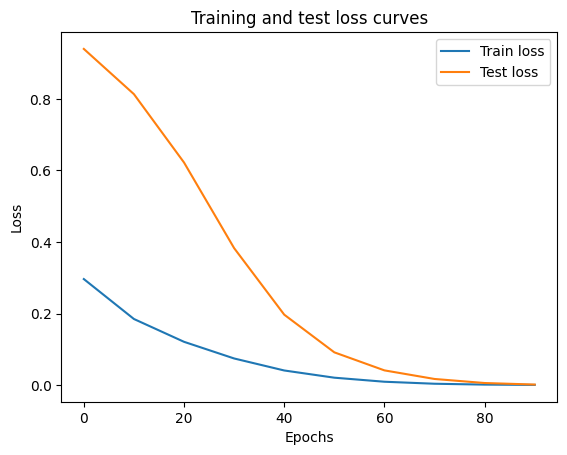

In [64]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

The model optimized the parameters to lower the train loss and test loss over time. 

In [65]:
model.state_dict()

OrderedDict([('weights', tensor([0.8919])), ('bias', tensor([0.1970]))])

The original parameters are 0.9 and 0.2

Our model got very close to calculating the exact original values for weight and bias

# Inference

In [66]:
model.eval()

with torch.inference_mode():
    y_preds = model(X_test)

y_preds

tensor([1.2673, 1.2852, 1.3030, 1.3208, 1.3387, 1.3565, 1.3744, 1.3922, 1.4100,
        1.4279, 1.4457, 1.4635, 1.4814, 1.4992, 1.5171, 1.5349, 1.5527, 1.5706,
        1.5884, 1.6062, 1.6241, 1.6419, 1.6598, 1.6776, 1.6954, 1.7133, 1.7311,
        1.7490, 1.7668, 1.7846, 1.8025, 1.8203, 1.8381, 1.8560, 1.8738, 1.8917,
        1.9095, 1.9273, 1.9452, 1.9630])

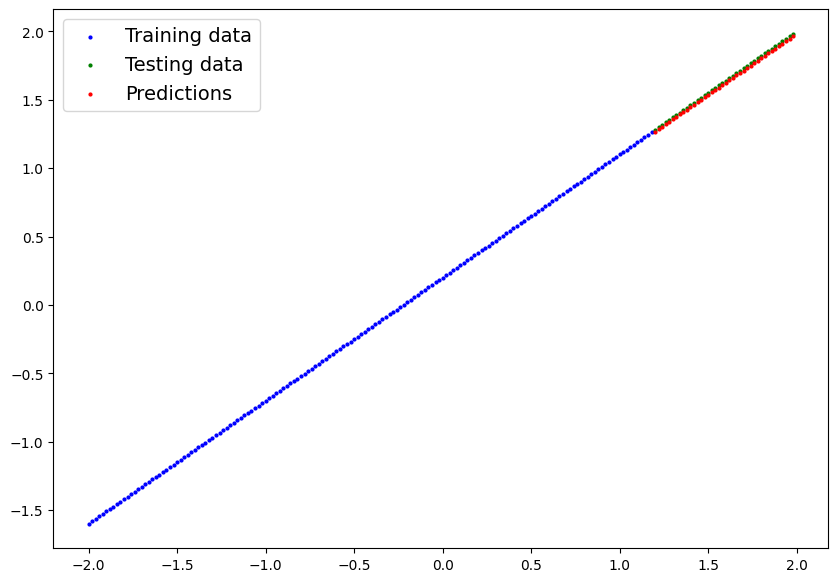

In [67]:
plot_predictions(predictions=y_preds)

# Save model

In [68]:
from pathlib import Path

# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path 
MODEL_NAME = "pytorch_workflow_fundamentals_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/pytorch_workflow_fundamentals_model.pth


# Load model

In [69]:
loaded_model = LinearRegressionModel()

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>